In [1]:
import os
import cv2
import numpy as np
import random
import shutil
from pathlib import Path
from tqdm import tqdm

class Config:
    """Configuration parameters for dataset preparation."""
    # Data split configuration
    VAL_SPLIT = 0.2  # Percentage of data for validation

    # Source paths
    RGB_SOURCE_PATH = "/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images"
    DEPTH_SOURCE_PATH = "/kaggle/input/fst-depth-map/vits"
    LABEL_SOURCE_PATH = "/kaggle/input/fst-mask-convert"
    
    # Target paths
    OUTPUT_BASE_PATH = "/kaggle/working/data"
    
    # File patterns
    RGB_PATTERN = "*.jpg"
    DEPTH_PATTERN = "*_depth.png"
    LABEL_PATTERN = "*.txt"
    
    # Class information
    CLASSES = {0: "fragment"}
    NUM_CLASSES = 1

def create_rgbd_dataset():
    """
    Create an RGBD dataset by combining RGB images with depth maps.
    Organizes files into train/val splits and saves as TIFF format.
    """
    # Get all RGB image paths
    rgb_files = sorted(list(Path(Config.RGB_SOURCE_PATH).glob(Config.RGB_PATTERN)))
    print(f"Found {len(rgb_files)} RGB images")
    
    # Create output directories
    output_dir = Path(Config.OUTPUT_BASE_PATH)
    images_dir = output_dir / "images"
    labels_dir = output_dir / "labels"
    train_img_dir = images_dir / "train"
    val_img_dir = images_dir / "val"
    train_label_dir = labels_dir / "train"
    val_label_dir = labels_dir / "val"
    
    for d in [train_img_dir, val_img_dir, train_label_dir, val_label_dir]:
        d.mkdir(parents=True, exist_ok=True)
    
    # Process files
    train_count = 0
    val_count = 0
    skipped_count = 0
    
    for rgb_path in tqdm(rgb_files, desc="Processing images"):
        # Extract base name without extension (e.g., "001")
        base_name = rgb_path.stem
        
        # Construct corresponding depth and label paths based on naming pattern (001.jpg -> 001_depth.png -> 001.txt)
        depth_path = Path(Config.DEPTH_SOURCE_PATH) / f"{base_name}_depth.png"
        label_path = Path(Config.LABEL_SOURCE_PATH) / f"{base_name}.txt"
        
        # Skip if files don't exist
        if not depth_path.exists() or not label_path.exists():
            skipped_count += 1
            continue
        
        # Decide train/val split
        if random.random() > Config.VAL_SPLIT:
            dest_img_dir, dest_lbl_dir = train_img_dir, train_label_dir
            train_count += 1
        else:
            dest_img_dir, dest_lbl_dir = val_img_dir, val_label_dir
            val_count += 1
        
        # Read RGB image
        rgb_img = cv2.imread(str(rgb_path))
        if rgb_img is None:
            print(f"Warning: Could not read {rgb_path}")
            skipped_count += 1
            continue
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        
        # Read depth image
        depth_img = cv2.imread(str(depth_path), cv2.IMREAD_GRAYSCALE)
        if depth_img is None:
            print(f"Warning: Could not read {depth_path}")
            skipped_count += 1
            continue
        
        # Resize depth to match RGB dimensions if needed
        h, w = rgb_img.shape[:2]
        if depth_img.shape[0] != h or depth_img.shape[1] != w:
            depth_img = cv2.resize(depth_img, (w, h))
        
        # Create 4-channel RGBD image (HWC format)
        rgbd_img = np.dstack((rgb_img, depth_img))
        
        # Save as TIFF
        output_path = dest_img_dir / f"{base_name}.tiff"
        
        # Split into individual channels and save as multi-page TIFF
        try:
            channels = [rgbd_img[:,:,i] for i in range(4)]
            success = cv2.imwritemulti(str(output_path), channels)
            if not success:
                raise Exception("Failed to write multi-page TIFF")
        except Exception as e:
            print(f"Error saving TIFF: {e}")
            # Fallback: save as 4-channel PNG (less ideal but workable)
            cv2.imwrite(str(output_path).replace('.tiff', '.png'), rgbd_img)
        
        # Copy label file
        shutil.copy(str(label_path), str(dest_lbl_dir / f"{base_name}.txt"))
    
    print(f"Dataset created: {train_count} training images, {val_count} validation images")
    print(f"Skipped {skipped_count} images due to missing files or errors")
    
    # Create dataset YAML file
    yaml_path = output_dir / "rgbd.yaml"
    with open(yaml_path, 'w') as f:
        f.write(f"# RGBD dataset configuration\n")
        f.write(f"path: {output_dir.absolute()}\n")
        f.write(f"train: images/train\n")
        f.write(f"val: images/val\n\n")
        f.write(f"# Number of channels (RGBD)\n")
        f.write(f"channels: 4\n\n")
        f.write(f"# Classes\n")
        f.write(f"nc: {Config.NUM_CLASSES}\n")
        f.write(f"names: {list(Config.CLASSES.values())}\n")
    
    print(f"Dataset configuration saved to {yaml_path}")
    return output_dir

if __name__ == "__main__":
    # Run the dataset creation
    dataset_path = create_rgbd_dataset() 

Found 768 RGB images


Processing images: 100%|██████████| 768/768 [00:49<00:00, 15.44it/s]

Dataset created: 607 training images, 161 validation images
Skipped 0 images due to missing files or errors
Dataset configuration saved to /kaggle/working/data/rgbd.yaml


In [4]:
!cat data/rgbd.yaml

# RGBD dataset configuration
path: /kaggle/working/data
train: images/train
val: images/val

# Number of channels (RGBD)
channels: 4

# Classes
nc: 1
names: ['fragment']


In [6]:
%%writefile requirements.txt
# Base packages for RGBD YOLOv8
ultralytics>=8.3.112
torch>=1.7.0
torchvision>=0.8.1
matplotlib>=3.2.2
numpy>=1.18.5
opencv-python>=4.1.2
PyYAML>=5.3.1
tqdm>=4.41.0
pillow>=7.1.2
seaborn>=0.11.0
scikit-learn>=0.19.2
setuptools>=65.5.1 

Writing requirements.txt


In [7]:
!pip install -r requirements.txt -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [8]:
%%writefile train_rgbd_model.py
import os
import yaml
from ultralytics import YOLO
from pathlib import Path

def train_rgbd_model(
    data_yaml_path,
    model_size='n',
    epochs=100,
    imgsz=640,
    batch=16,
    patience=20,
    device=0
):
    """
    Train a YOLOv8 segmentation model on RGBD (4-channel) data.
    
    Args:
        data_yaml_path: Path to the dataset YAML file
        model_size: Model size (n, s, m, l, x)
        epochs: Number of training epochs
        imgsz: Input image size
        batch: Batch size
        patience: Early stopping patience
        device: Training device (GPU id or 'cpu')
    
    Returns:
        Trained model
    """
    print(f"Starting training with YOLOv8{model_size}-seg on RGBD data...")
    
    # Verify the dataset YAML has channels=4
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    
    if 'channels' not in data_config or data_config['channels'] != 4:
        print(f"Warning: Dataset YAML does not specify channels=4. Adding it...")
        data_config['channels'] = 4
        with open(data_yaml_path, 'w') as f:
            yaml.dump(data_config, f, default_flow_style=False)
    
    # Load pre-trained YOLOv8 segmentation model
    # The first layer will be automatically adapted for 4 channels
    model = YOLO(f'yolov8{model_size}-seg.pt')
    
    # Print model summary to verify the first layer has 4 input channels
    model.info()
    
    # Train the model
    results = model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        patience=patience,
        device=device,
        optimizer='Adam',
        lr0=0.001,
        lrf=0.1,
        save=True,
        plots=True
    )
    
    print(f"Training completed. Model saved at: {model.trainer.best}")
    
    # Validate the model
    print("Validating model...")
    val_results = model.val()
    
    # Save the final model
    save_dir = Path(model.trainer.save_dir)
    final_model_path = save_dir / 'rgbd_model.pt'
    model.save(final_model_path)
    print(f"Final model saved to: {final_model_path}")
    
    return model

if __name__ == "__main__":
    # Check if RGBD dataset exists, otherwise create it
    if not Path("./data/rgbd.yaml").exists():
        print("RGBD dataset not found. Creating it first...")
        from rgbd_dataset import create_rgbd_dataset
        dataset_path = create_rgbd_dataset()
        data_yaml_path = str(dataset_path / "rgbd.yaml")
    else:
        data_yaml_path = "./data/rgbd.yaml"
    
    # Train model
    model = train_rgbd_model(
        data_yaml_path=data_yaml_path,
        model_size='n',  # Use nano version as requested
        epochs=100,
        imgsz=640,
        batch=16,
        patience=5
    ) 

Writing train_rgbd_model.py


In [16]:
%%writefile rgbd_dataset.py
import os
import cv2
import numpy as np
import random
import shutil
from pathlib import Path
from tqdm import tqdm

class Config:
    """Configuration parameters for dataset preparation."""
    # Data split configuration
    VAL_SPLIT = 0.2  # Percentage of data for validation

    # Source paths
    RGB_SOURCE_PATH = "/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images"
    DEPTH_SOURCE_PATH = "/kaggle/input/fst-depth-map/vits"
    LABEL_SOURCE_PATH = "/kaggle/input/fst-mask-convert"
    
    # Target paths
    OUTPUT_BASE_PATH = "/kaggle/working/data"
    
    # File patterns
    RGB_PATTERN = "*.jpg"
    DEPTH_PATTERN = "*_depth.png"
    LABEL_PATTERN = "*.txt"
    
    # Class information
    CLASSES = {0: "fragment"}
    NUM_CLASSES = 1

def create_rgbd_dataset():
    """
    Create an RGBD dataset by combining RGB images with depth maps.
    Organizes files into train/val splits and saves as TIFF format.
    """
    # Get all RGB image paths
    rgb_files = sorted(list(Path(Config.RGB_SOURCE_PATH).glob(Config.RGB_PATTERN)))
    print(f"Found {len(rgb_files)} RGB images")
    
    # Create output directories
    output_dir = Path(Config.OUTPUT_BASE_PATH)
    images_dir = output_dir / "images"
    labels_dir = output_dir / "labels"
    train_img_dir = images_dir / "train"
    val_img_dir = images_dir / "val"
    train_label_dir = labels_dir / "train"
    val_label_dir = labels_dir / "val"
    
    for d in [train_img_dir, val_img_dir, train_label_dir, val_label_dir]:
        d.mkdir(parents=True, exist_ok=True)
    
    # Process files
    train_count = 0
    val_count = 0
    skipped_count = 0
    
    for rgb_path in tqdm(rgb_files, desc="Processing images"):
        # Extract base name without extension (e.g., "001")
        base_name = rgb_path.stem
        
        # Construct corresponding depth and label paths based on naming pattern (001.jpg -> 001_depth.png -> 001.txt)
        depth_path = Path(Config.DEPTH_SOURCE_PATH) / f"{base_name}_depth.png"
        label_path = Path(Config.LABEL_SOURCE_PATH) / f"{base_name}.txt"
        
        # Skip if files don't exist
        if not depth_path.exists() or not label_path.exists():
            skipped_count += 1
            continue
        
        # Decide train/val split
        if random.random() > Config.VAL_SPLIT:
            dest_img_dir, dest_lbl_dir = train_img_dir, train_label_dir
            train_count += 1
        else:
            dest_img_dir, dest_lbl_dir = val_img_dir, val_label_dir
            val_count += 1
        
        # Read RGB image
        rgb_img = cv2.imread(str(rgb_path))
        if rgb_img is None:
            print(f"Warning: Could not read {rgb_path}")
            skipped_count += 1
            continue
        rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
        
        # Read depth image
        depth_img = cv2.imread(str(depth_path), cv2.IMREAD_GRAYSCALE)
        if depth_img is None:
            print(f"Warning: Could not read {depth_path}")
            skipped_count += 1
            continue
        
        # Resize depth to match RGB dimensions if needed
        h, w = rgb_img.shape[:2]
        if depth_img.shape[0] != h or depth_img.shape[1] != w:
            depth_img = cv2.resize(depth_img, (w, h))
        
        # Create 4-channel RGBD image (HWC format)
        rgbd_img = np.dstack((rgb_img, depth_img))
        
        # Save as TIFF
        output_path = dest_img_dir / f"{base_name}.tiff"
        
        # Split into individual channels and save as multi-page TIFF
        try:
            channels = [rgbd_img[:,:,i] for i in range(4)]
            success = cv2.imwritemulti(str(output_path), channels)
            if not success:
                raise Exception("Failed to write multi-page TIFF")
        except Exception as e:
            print(f"Error saving TIFF: {e}")
            # Fallback: save as 4-channel PNG (less ideal but workable)
            cv2.imwrite(str(output_path).replace('.tiff', '.png'), rgbd_img)
        
        # Copy label file
        shutil.copy(str(label_path), str(dest_lbl_dir / f"{base_name}.txt"))
    
    print(f"Dataset created: {train_count} training images, {val_count} validation images")
    print(f"Skipped {skipped_count} images due to missing files or errors")
    
    # Create dataset YAML file
    yaml_path = output_dir / "rgbd.yaml"
    with open(yaml_path, 'w') as f:
        f.write(f"# RGBD dataset configuration\n")
        f.write(f"path: {output_dir.absolute()}\n")
        f.write(f"train: images/train\n")
        f.write(f"val: images/val\n\n")
        f.write(f"# Number of channels (RGBD)\n")
        f.write(f"channels: 4\n\n")
        f.write(f"# Classes\n")
        f.write(f"nc: {Config.NUM_CLASSES}\n")
        f.write(f"names: {list(Config.CLASSES.values())}\n")
    
    print(f"Dataset configuration saved to {yaml_path}")
    return output_dir

if __name__ == "__main__":
    # Run the dataset creation
    dataset_path = create_rgbd_dataset() 

Writing rgbd_dataset.py


In [17]:
!python train_rgbd_model.py

RGBD dataset not found. Creating it first...
Found 768 RGB images
Processing images: 100%|██████████████████████| 768/768 [00:23<00:00, 32.18it/s]
Dataset created: 615 training images, 153 validation images
Skipped 0 images due to missing files or errors
Dataset configuration saved to /kaggle/working/data/rgbd.yaml
Starting training with YOLOv8n-seg on RGBD data...
100%|███████████████████████████████████████| 6.74M/6.74M [00:00<00:00, 115MB/s]
YOLOv8n-seg summary: 151 layers, 3,409,968 parameters, 0 gradients, 12.8 GFLOPs
Ultralytics 8.3.133 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data/rgbd.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=Fa

In [19]:
%%writefile rgbd_inference.py
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path

def load_rgbd_image(rgb_path, depth_path):
    """
    Load and combine RGB and depth images into a 4-channel RGBD image.
    
    Args:
        rgb_path: Path to the RGB image
        depth_path: Path to the depth image
    
    Returns:
        rgbd_img: 4-channel RGBD image
    """
    # Load RGB image
    rgb_img = cv2.imread(str(rgb_path))
    if rgb_img is None:
        raise ValueError(f"Could not read RGB image at {rgb_path}")
    rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
    
    # Load depth image
    depth_img = cv2.imread(str(depth_path), cv2.IMREAD_GRAYSCALE)
    if depth_img is None:
        raise ValueError(f"Could not read depth image at {depth_path}")
    
    # Resize depth to match RGB dimensions if needed
    h, w = rgb_img.shape[:2]
    if depth_img.shape[0] != h or depth_img.shape[1] != w:
        depth_img = cv2.resize(depth_img, (w, h))
    
    # Create 4-channel RGBD image
    rgbd_img = np.dstack((rgb_img, depth_img))
    
    return rgbd_img

def perform_inference(model_path, rgb_path, depth_path):
    """
    Perform inference on an RGBD image pair.
    
    Args:
        model_path: Path to the trained YOLO model
        rgb_path: Path to the RGB image
        depth_path: Path to the depth image
    
    Returns:
        results: Inference results
        rgbd_img: 4-channel RGBD image
    """
    # Load model
    model = YOLO(model_path)
    
    # Load RGBD image
    rgbd_img = load_rgbd_image(rgb_path, depth_path)
    
    # Run inference
    results = model(rgbd_img)
    
    return results, rgbd_img

def visualize_results(results, rgbd_img, save_path=None):
    """
    Visualize inference results.
    
    Args:
        results: Inference results from YOLO model
        rgbd_img: 4-channel RGBD image
        save_path: Path to save the visualization (optional)
    """
    # Extract RGB and depth channels for visualization
    rgb_vis = rgbd_img[:,:,:3]  # Just the RGB channels
    depth_vis = rgbd_img[:,:,3]  # Depth channel
    
    plt.figure(figsize=(16, 12))
    
    # RGB input
    plt.subplot(2, 2, 1)
    plt.imshow(rgb_vis)
    plt.title('RGB Input')
    plt.axis('off')
    
    # Depth input
    plt.subplot(2, 2, 2)
    plt.imshow(depth_vis, cmap='gray')
    plt.title('Depth Channel')
    plt.axis('off')
    
    # Segmentation result
    plt.subplot(2, 2, 3)
    plt.imshow(results[0].plot())
    plt.title('Segmentation Result')
    plt.axis('off')
    
    # Masks only
    plt.subplot(2, 2, 4)
    if hasattr(results[0], 'masks') and results[0].masks is not None and len(results[0].masks) > 0:
        mask = results[0].masks.data[0].cpu().numpy()
        plt.imshow(mask, cmap='jet', alpha=0.7)
        plt.imshow(rgb_vis, alpha=0.3)
        plt.title('Segmentation Mask')
    else:
        plt.imshow(rgb_vis)
        plt.title('No Mask Available')
    plt.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to: {save_path}")
    
    plt.show()

def process_directory(model_path, rgb_dir, depth_dir, pattern="*.jpg", output_dir=None):
    """
    Process all matching image pairs in the given directories.
    
    Args:
        model_path: Path to the trained YOLO model
        rgb_dir: Directory containing RGB images
        depth_dir: Directory containing depth images
        pattern: File pattern to match
        output_dir: Directory to save visualizations (optional)
    """
    rgb_files = sorted(list(Path(rgb_dir).glob(pattern)))
    print(f"Found {len(rgb_files)} RGB images to process")
    
    # Create output directory if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Load model
    model = YOLO(model_path)
    
    for rgb_path in rgb_files:
        base_name = rgb_path.stem
        depth_path = Path(depth_dir) / f"{base_name}_depth.png"
        
        if not depth_path.exists():
            print(f"Skipping {base_name}: No matching depth image found")
            continue
        
        try:
            # Process image pair
            print(f"Processing {base_name}...")
            results, rgbd_img = perform_inference(model, rgb_path, depth_path)
            
            # Save visualization if requested
            if output_dir:
                save_path = Path(output_dir) / f"{base_name}_result.png"
                visualize_results(results, rgbd_img, save_path)
            else:
                visualize_results(results, rgbd_img)
                
        except Exception as e:
            print(f"Error processing {base_name}: {e}")

if __name__ == "__main__":
    # Example usage
    model_path = "runs/segment/train/rgbd_model.pt"
    
    # Process a single image
    rgb_path = "sample_rgb.jpg"
    depth_path = "sample_depth.png"
    
    if Path(rgb_path).exists() and Path(depth_path).exists():
        results, rgbd_img = perform_inference(model_path, rgb_path, depth_path)
        visualize_results(results, rgbd_img, "sample_result.png")
    else:
        print("Sample images not found. Please provide valid RGB and depth images.")
    
    # Uncomment to process a directory
    """
    process_directory(
        model_path=model_path,
        rgb_dir="/path/to/rgb_images",
        depth_dir="/path/to/depth_images",
        output_dir="results"
    )
    """ 

Writing rgbd_inference.py


In [24]:
!pwd /kaggle/working/rgbd-yolov8/runs/segment/train/rgbd_model.pt

/kaggle/working/rgbd-yolov8


In [25]:
!ls /kaggle/working/rgbd-yolov8/runs

segment


Model loaded successfully from /kaggle/working/rgbd-yolov8/runs/segment/train/rgbd_model.pt

Evaluating inference time with 50 separate runs...
Performing a warm-up inference run...
Warm-up complete.
Completed run 10/50 on 120.jpg/120_depth.png in 0.2487s
Completed run 20/50 on 437.jpg/437_depth.png in 0.2735s
Completed run 30/50 on 530.jpg/530_depth.png in 0.4091s
Completed run 40/50 on 205.jpg/205_depth.png in 0.3184s
Completed run 50/50 on 794.jpg/794_depth.png in 0.4468s

--- RGBD Separate Inference Runs Timing Summary ---
Number of runs successfully timed: 50 / 50
Total time for all 50 separate runs: 20.6935 seconds
Average inference time per run: 0.4139 seconds
Median inference time per run: 0.3570 seconds
Minimum inference time per run: 0.1240 seconds
Maximum inference time per run: 1.1669 seconds
Standard deviation of inference time: 0.2042 seconds

--- Running and Visualizing One RGBD Example ---
Running inference for visualization on: /kaggle/input/gd-go-c-hcmus-aic-fragment-

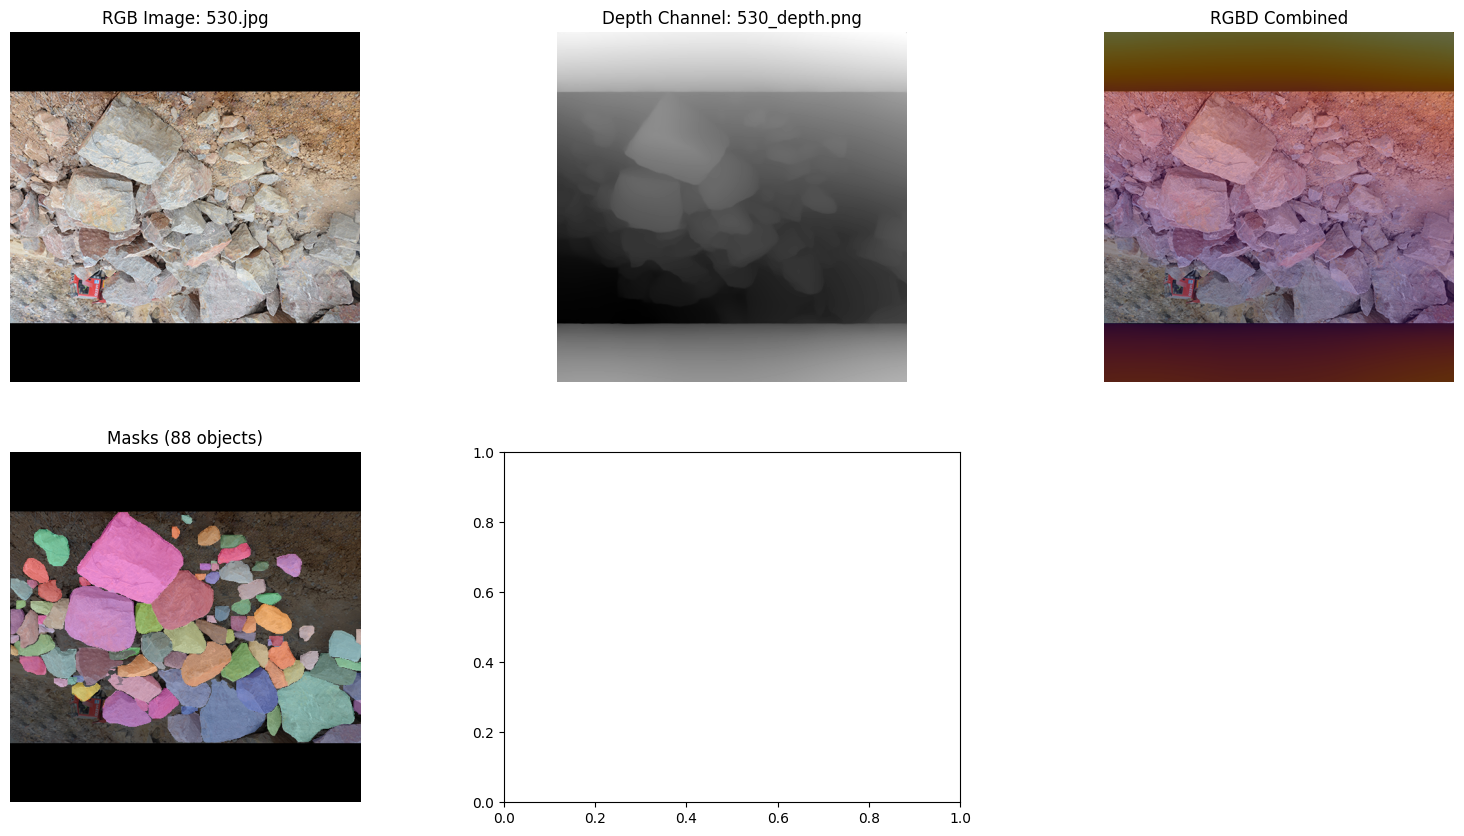

In [26]:
import os
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import cv2
import time
from pathlib import Path
from rgbd_inference import load_rgbd_image

# Set random seed for reproducibility
torch.manual_seed(40)
np.random.seed(40)
random.seed(40)

class Config:
    def __init__(self):
        # Model settings
        self.model_path = '/kaggle/working/rgbd-yolov8/runs/segment/train/rgbd_model.pt'  # Path to trained model
        
        # Inference settings
        self.conf_threshold = 0.25  # Confidence threshold
        self.iou_threshold = 0.7    # IoU threshold for NMS
        self.device = 'cpu'         # Force CPU usage
        
        # --- Settings for Separate Inference Runs Timing ---
        self.rgb_image_dir_path = '/kaggle/input/gd-go-c-hcmus-aic-fragment-segmentation-track/train/images'
        self.depth_image_dir_path = '/kaggle/input/fst-depth-map/vits'
        self.num_separate_runs_for_timing = 50 # Number of separate inference runs on different images

        # --- Output Settings for the Single Visualized Example ---
        self.output_path_base = '/kaggle/working/rgbd_inference_eval_outputs' 
        
        # Inference/Visualization settings for YOLO predict calls
        self.imgsz = 512            # Same size used during training
        self.show_labels = False    # Set to True to show labels
        self.show_conf = False      # Set to True to show confidences
        self.show_boxes = False     # Set to True to show bounding boxes
        
        # Class information
        self.classes = ['fragment']  # Single class: fragment

def load_model(config):
    """Load the trained YOLOv8 model"""
    try:
        model = YOLO(config.model_path)
        print(f"Model loaded successfully from {config.model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

def get_random_image_pairs(rgb_dir_str, depth_dir_str, num_pairs, extensions=('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
    """Gets a list of random RGB-Depth image pairs."""
    rgb_dir = Path(rgb_dir_str)
    depth_dir = Path(depth_dir_str)
    
    if not rgb_dir.is_dir():
        print(f"Error: Provided RGB image path '{rgb_dir_str}' is not a directory.")
        return []
    if not depth_dir.is_dir():
        print(f"Error: Provided depth image path '{depth_dir_str}' is not a directory.")
        return []

    # Get all RGB image files
    all_rgb_files = []
    for ext in extensions:
        all_rgb_files.extend(list(rgb_dir.glob(f'*{ext}')))
    
    all_rgb_files = [str(p) for p in all_rgb_files] 

    if not all_rgb_files:
        print(f"No RGB images found in '{rgb_dir_str}' with extensions {extensions}")
        return []

    # Filter to include only images that have matching depth maps
    matched_pairs = []
    for rgb_path in all_rgb_files:
        base_name = Path(rgb_path).stem
        depth_path = str(depth_dir / f"{base_name}_depth.png")
        if os.path.exists(depth_path):
            matched_pairs.append((rgb_path, depth_path))
    
    if not matched_pairs:
        print(f"No matching RGB-Depth pairs found.")
        return []

    if len(matched_pairs) < num_pairs:
        print(f"Warning: Requested {num_pairs} pairs, but only found {len(matched_pairs)}. Using all {len(matched_pairs)} found pairs.")
        if not matched_pairs: 
            return []
        return random.choices(matched_pairs, k=num_pairs)
    else:
        return random.sample(matched_pairs, num_pairs)

def evaluate_separate_inference_runs(model, image_pairs, config):
    """Runs a separate model.predict() call for each RGBD image pair and collects timing."""
    if not model:
        print("No model loaded. Cannot run inference for timing evaluation.")
        return None

    inference_times = []
    
    print(f"\nEvaluating inference time with {len(image_pairs)} separate runs...")
    
    if image_pairs:
        print("Performing a warm-up inference run...")
        valid_warmup_pair = next((p for p in image_pairs if os.path.exists(p[0]) and os.path.exists(p[1])), None)
        if valid_warmup_pair:
            try:
                rgb_path, depth_path = valid_warmup_pair
                # Load RGBD image
                rgbd_img = load_rgbd_image(rgb_path, depth_path)
                
                # Run warm-up inference
                _ = model.predict(
                    source=rgbd_img,  # Pass RGBD numpy array directly
                    conf=config.conf_threshold, 
                    iou=config.iou_threshold, 
                    imgsz=config.imgsz,
                    device=config.device, 
                    save=False, 
                    visualize=False, 
                    verbose=False,
                    retina_masks=True, 
                    show_boxes=config.show_boxes
                )
                print("Warm-up complete.")
            except Exception as e:
                print(f"Warm-up run failed for {valid_warmup_pair}: {e}")
        else:
            print("Warm-up skipped: No valid image pairs found in the provided list for warm-up.")

    for i, (rgb_path, depth_path) in enumerate(image_pairs):
        if not os.path.exists(rgb_path) or not os.path.exists(depth_path):
            print(f"RGB or depth image not found at {rgb_path} or {depth_path}, skipping run {i+1}.")
            continue

        try:
            # Load RGBD image
            rgbd_img = load_rgbd_image(rgb_path, depth_path)
            
            # Run inference and time it
            start_time = time.time()
            _ = model.predict(
                source=rgbd_img,  # Pass RGBD numpy array directly
                conf=config.conf_threshold,
                iou=config.iou_threshold,
                imgsz=config.imgsz,
                device=config.device,
                save=False, 
                save_txt=False, 
                project=None, 
                name=None,
                visualize=False, 
                show_labels=config.show_labels,
                show_conf=config.show_conf,
                show_boxes=config.show_boxes,
                retina_masks=True, 
                verbose=False 
            )
            end_time = time.time()
            current_inference_time = end_time - start_time
            inference_times.append(current_inference_time)
            if (i + 1) % 10 == 0 or i == len(image_pairs) - 1:
                 print(f"Completed run {i+1}/{len(image_pairs)} on {Path(rgb_path).name}/{Path(depth_path).name} in {current_inference_time:.4f}s")
        except Exception as e:
            print(f"Error during inference for {rgb_path}/{depth_path} (run {i+1}): {e}")
            
    if not inference_times:
        print("No images were successfully processed for timing.")
        return []
        
    return inference_times

def visualize_rgbd_result(result, rgb_path, depth_path, inference_time, output_visualization_path, config):
    """Visualize RGBD image prediction with side-by-side comparison.
       Saves the custom plot to output_visualization_path.
    """
    if result is None:
        print("No result to visualize")
        return
    
    os.makedirs(Path(output_visualization_path).parent, exist_ok=True)
    
    # Load RGBD image
    rgbd_img = load_rgbd_image(rgb_path, depth_path)
    rgb_img = rgbd_img[:,:,:3]  # Extract RGB channels
    depth_img = rgbd_img[:,:,3]  # Extract depth channel
    
    plt.figure(figsize=(20, 10))
    
    # Original RGB image
    plt.subplot(2, 3, 1)
    try:
        plt.imshow(rgb_img)
        plt.title(f"RGB Image: {Path(rgb_path).name}")
    except Exception as e:
        plt.title(f"Could not load RGB: {Path(rgb_path).name}\n{e}")
    plt.axis('off')
    
    # Depth image
    plt.subplot(2, 3, 2)
    try:
        plt.imshow(depth_img, cmap='gray')
        plt.title(f"Depth Channel: {Path(depth_path).name}")
    except Exception as e:
        plt.title(f"Could not load depth: {Path(depth_path).name}\n{e}")
    plt.axis('off')
    
    # Combined RGBD visualization (RGB with depth as alpha)
    plt.subplot(2, 3, 3)
    try:
        # Normalize depth for visualization
        depth_normalized = depth_img / (np.max(depth_img) + 1e-10)
        plt.imshow(rgb_img)
        plt.imshow(depth_normalized, cmap='inferno', alpha=0.4)
        plt.title("RGBD Combined")
    except Exception as e:
        plt.title(f"Could not create RGBD visualization\n{e}")
    plt.axis('off')
    
    # Segmentation masks
    plt.subplot(2, 3, 4)
    if hasattr(result, 'masks') and result.masks is not None and len(result.masks.data) > 0:
        masks_data = result.masks.data.cpu().numpy()
        mask_img = np.zeros_like(rgb_img)
        
        for j, mask in enumerate(masks_data):
            color = np.array([random.randint(50, 255), random.randint(50, 200), random.randint(50, 200)])
            mask_h, mask_w = mask.shape
            img_h, img_w = rgb_img.shape[:2]
            bin_mask = mask.astype('uint8')
            if mask_h != img_h or mask_w != img_w:
                bin_mask = cv2.resize(bin_mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
            mask_img[bin_mask > 0] = color
        
        alpha = 0.6
        blended = cv2.addWeighted(rgb_img, 1 - alpha, mask_img, alpha, 0)
        plt.imshow(blended)
        plt.title(f"Masks ({len(masks_data)} objects)")
    else:
        plt.imshow(rgb_img)
        plt.title("No masks detected")
    plt.axis('off')
    
    # Default YOLO visualization
    plt.subplot(2, 3, 5)
    plt.imshow(result.plot(
        show_boxes=config.show_boxes, 
        show_labels=config.show_labels, 
        show_conf=config.show_conf
    ))
    plt.title(f"YOLO Prediction ({inference_time:.3f}s)")
    plt.axis('off')
    
    # Depth with mask overlay
    plt.subplot(2, 3, 6)
    if hasattr(result, 'masks') and result.masks is not None and len(result.masks.data) > 0:
        # Create a colormap for the depth
        depth_colored = plt.cm.viridis(depth_normalized)[:, :, :3]  # Convert depth to RGB using colormap
        
        # Create an overlay of masks
        mask_overlay = np.zeros_like(depth_colored)
        for j, mask in enumerate(masks_data):
            mask_h, mask_w = mask.shape
            img_h, img_w = rgb_img.shape[:2]
            bin_mask = mask.astype('uint8')
            if mask_h != img_h or mask_w != img_w:
                bin_mask = cv2.resize(bin_mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
            
            # Create a colored mask
            color = np.array([random.random(), random.random(), random.random()])
            for c in range(3):
                mask_overlay[:, :, c] = np.where(bin_mask > 0, color[c], mask_overlay[:, :, c])
        
        # Blend depth with mask overlay
        depth_blend = 0.7 * depth_colored + 0.3 * mask_overlay
        plt.imshow(depth_blend)
        plt.title("Depth with Mask Overlay")
    else:
        plt.imshow(depth_normalized, cmap='viridis')
        plt.title("Depth (No masks detected)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_visualization_path)
    print(f"Custom RGBD visualization saved to {output_visualization_path}")
    plt.show()
    plt.close()

def main():
    """Main function"""
    config = Config() 
    
    model = load_model(config)
    if not model:
        return

    image_pairs = get_random_image_pairs(
        config.rgb_image_dir_path, 
        config.depth_image_dir_path, 
        config.num_separate_runs_for_timing
    )
    
    if not image_pairs:
        print(f"No image pairs found for evaluation. Exiting timing evaluation.")
    else:
        all_separate_inference_times = evaluate_separate_inference_runs(model, image_pairs, config)

        if all_separate_inference_times:
            valid_times = [t for t in all_separate_inference_times if not np.isnan(t)]
            if not valid_times:
                print("No valid inference times recorded.")
            else:
                total_time_all_runs = sum(valid_times)
                avg_time = np.mean(valid_times)
                min_time = min(valid_times)
                max_time = max(valid_times)
                std_dev_time = np.std(valid_times)
                median_time = np.median(valid_times)
                
                print("\n--- RGBD Separate Inference Runs Timing Summary ---")
                print(f"Number of runs successfully timed: {len(valid_times)} / {len(image_pairs)}")
                print(f"Total time for all {len(valid_times)} separate runs: {total_time_all_runs:.4f} seconds")
                print(f"Average inference time per run: {avg_time:.4f} seconds")
                print(f"Median inference time per run: {median_time:.4f} seconds")
                print(f"Minimum inference time per run: {min_time:.4f} seconds")
                print(f"Maximum inference time per run: {max_time:.4f} seconds")
                print(f"Standard deviation of inference time: {std_dev_time:.4f} seconds")
        else:
            print("Separate inference runs timing did not produce any results.")

        if image_pairs:
            print("\n--- Running and Visualizing One RGBD Example ---")
            
            example_pair = random.choice(image_pairs)
            rgb_path, depth_path = example_pair
            
            if not os.path.exists(rgb_path) or not os.path.exists(depth_path):
                print(f"Selected example images {rgb_path} or {depth_path} not found. Skipping visualization.")
            else:
                example_specific_output_folder_name = f"visualized_rgbd_example_{Path(rgb_path).stem}"
                yolo_project_dir = Path(config.output_path_base)
                yolo_run_name = example_specific_output_folder_name 
                
                os.makedirs(yolo_project_dir / yolo_run_name, exist_ok=True)
                
                print(f"Running inference for visualization on: {rgb_path} and {depth_path}")
                
                try:
                    # Load RGBD image
                    rgbd_img = load_rgbd_image(rgb_path, depth_path)
                    
                    start_time_single_viz = time.time()
                    results_single_list = model.predict(
                        source=rgbd_img,
                        conf=config.conf_threshold, 
                        iou=config.iou_threshold, 
                        imgsz=config.imgsz,
                        device=config.device,
                        save=True,          
                        save_txt=False,
                        project=str(yolo_project_dir), 
                        name=yolo_run_name,       
                        visualize=False,    
                        show_labels=config.show_labels,
                        show_conf=config.show_conf,
                        show_boxes=config.show_boxes,
                        retina_masks=True, 
                        verbose=True 
                    )
                    end_time_single_viz = time.time()
                    inference_time_single_viz = end_time_single_viz - start_time_single_viz
                    print(f"Single RGBD example inference (for visualization) completed in {inference_time_single_viz:.4f} seconds")

                    if results_single_list:
                        result_single = results_single_list[0]
                        custom_plot_filename = f"custom_rgbd_visualization_{Path(rgb_path).stem}.png"
                        # Ensure result_single.save_dir is valid, otherwise use a fallback
                        save_dir_path = Path(result_single.save_dir) if hasattr(result_single, 'save_dir') and result_single.save_dir else yolo_project_dir / yolo_run_name / "predict" # Fallback if save_dir is None
                        if not save_dir_path.exists():
                            save_dir_path.mkdir(parents=True, exist_ok=True) # Create if it doesn't exist
                        custom_plot_save_path = save_dir_path / custom_plot_filename
                        
                        visualize_rgbd_result(result_single, rgb_path, depth_path, inference_time_single_viz, str(custom_plot_save_path), config)
                    else:
                        print("No results returned for the single RGBD example visualization.")
                except Exception as e:
                    print(f"Error during single RGBD example inference/visualization for {rgb_path} and {depth_path}: {e}")
        else:
            print("\nSkipping single example visualization as no image pairs were selected for timing runs.")

    print("\nRGBD evaluation script finished.")

if __name__ == '__main__':
    main() 